<a href="https://colab.research.google.com/github/Kan4me/TesteLocaliza/blob/main/TesteLocaliza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Teste Prático Localiza

Realizar o treino de um modelo preditivo que seja capaz de identificar se o Cliente será Adiplente (0) ou Inadimplente (1), conforme base disponibilizada.

* Conexão com o Google Drive e instalação dos pacotes que serão utilizados

In [1]:
# pip install PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
#Mounted Google Drive de interesse
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
# Configuração das bibliotecas de interesse
!pip install scikit-plot
!pip install eli5

import pandas as pd
import seaborn as sns
import numpy as np
import datetime
import matplotlib.pyplot as plt
import sklearn as sk
import scikitplot as skplt


from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import StrMethodFormatter
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report


from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import export_graphviz
import pydot

import eli5
from eli5.sklearn import PermutationImportance


     |████████████████████████████████| 112kB 3.4MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from 

* A base disponibilizada encontra-se em formato .csv

In [4]:
#Carregar arquivo XLSX de interesse

base = '/content/drive/My Drive/AnaliseLocaliza/inadimplencia.csv'

base_dados = pd.read_csv(base)
base_dados.head()

UnicodeDecodeError: ignored

* Como houve erro para carregar a base, foi necessário realizar um outro tipo de procedimento

In [5]:
import chardet

with open(base, 'rb') as rawdata:

    result = chardet.detect(rawdata.read(100000))

result

{'confidence': 0.73, 'encoding': 'ISO-8859-1', 'language': ''}

In [6]:
base_dados = pd.read_csv(base, encoding='ISO-8859-1', sep =';')
base_dados.head()

,Cliente,dt_nascimento,cd_estado,cd_pais,ind_inadimpl,cd_contrato,data_abertura,regiao_moradia,contratos_anteriores,data_primeiro_contrato,tempo_primeiro_contrato,situacao_pagamento,tempo_maximo_atraso,atraso_anterior
0,d7f109c2528d9e67b0a4aefc506e0829,1928/01/18 00:00:00,PE,55,1,5c0df077b7e4059882c71d545ada5d02,08/02/2018,Nordeste,3,20/01/2018,0,Faturas quitadas,0,Nenhum atraso anterior
1,ed686356fc436976a2a1bc6b0ba4b689,1930/03/20 00:00:00,SP,55,1,bba0ba46d3014b8730d46ee517bd26ac,13/12/2018,São Paulo,6,14/06/1996,269,Faturas quitadas,20,Até 30 dias de atraso
2,b1934e915a7613f4f045c7bb1e650da4,1930/05/06 00:00:00,SP,55,1,5568836053503c035f5647dca25fd637,03/01/2019,São Paulo,0,03/01/2019,0,Nenhuma fatura anterior,0,Nenhum atraso anterior
3,fcf19843ab8de3a1e3c4384cf7b076cb,1931/08/27 00:00:00,SP,55,1,6a0c1170901c77a878f174c870969085,20/04/2018,São Paulo,1,06/09/2017,7,Faturas quitadas,127,Mais de 30 dias de atraso
4,360f4c4d9c168f6c09aa5cd76d4f575c,1931/09/30 00:00:00,DF,55,1,3197dedf72fc4d8a20c7ee236cfff562,24/10/2018,Centro-Oeste,4,02/10/1995,276,Nenhuma fatura anterior,0,Nenhum atraso anterior


In [7]:
base_dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91638 entries, 0 to 91637
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Cliente                  91638 non-null  object
 1   dt_nascimento            91638 non-null  object
 2   cd_estado                91618 non-null  object
 3   cd_pais                  91638 non-null  int64 
 4   ind_inadimpl             91638 non-null  int64 
 5   cd_contrato              91638 non-null  object
 6   data_abertura            91638 non-null  object
 7   regiao_moradia           91638 non-null  object
 8   contratos_anteriores     91638 non-null  int64 
 9   data_primeiro_contrato   91638 non-null  object
 10  tempo_primeiro_contrato  91638 non-null  int64 
 11  situacao_pagamento       91638 non-null  object
 12  tempo_maximo_atraso      91638 non-null  int64 
 13  atraso_anterior          91638 non-null  object
dtypes: int64(5), object(9)
memory usage: 9

* Percebe-se que a base disponibilizada possui 14 variáveis numéricas e categóricas.

* Descrição das variáveis:
> <br> **Cliente**: Identificação Cliente 
> <br> **dt_nascimento**: Data Nascimento Cliente 
> <br> **cd_estado**: Estado de residência Cliente
> <br> **cd_pais**: País
> <br> **ind_inadimpl**: Target: 1 Indica que o Cliente deve ser considerado Inadimplente
> <br> **cd_contrato**: Contrato Cliente avaliado
> <br> **data_abertura**: Data abertura contrato
> <br> **regiao_moradia**: Região Brasileira endereço Cliente
> <br> **contratos_anteriores**: Quantidade de contratos já abertos
> <br> **data_primeiro_contrato**: Data da primeira contratação
> <br> **tempo_primeiro_contrato**: Número de meses inteiros entre a data de abertura do primeiro contrato do cliente e a data de abertura do contrato de referência.
> <br> **situacao_pagamento**: Status financeiro atual
> <br> **tempo_maximo_atraso**: Ageing máximo que atrasou um pagamento
> <br> **atraso_anterior**: Indica se o cliente, na data da abertura do contrato de referência, tinha valores vencidos em aberto. Contém as categorias “Nenhuma fatura anterior”, “Faturas quitadas” e “Tem valores em aberto”.</br>



* Manipulação base de dados - Ajuste variável 'dt_nascimento' e criação coluna Mês e Ano do Contatro de Referência

In [8]:
base_dados['data_nascimento'] = pd.to_datetime(base_dados['dt_nascimento'], utc=False)

base_dados.head()

,Cliente,dt_nascimento,cd_estado,cd_pais,ind_inadimpl,cd_contrato,data_abertura,regiao_moradia,contratos_anteriores,data_primeiro_contrato,tempo_primeiro_contrato,situacao_pagamento,tempo_maximo_atraso,atraso_anterior,data_nascimento
0,d7f109c2528d9e67b0a4aefc506e0829,1928/01/18 00:00:00,PE,55,1,5c0df077b7e4059882c71d545ada5d02,08/02/2018,Nordeste,3,20/01/2018,0,Faturas quitadas,0,Nenhum atraso anterior,1928-01-18
1,ed686356fc436976a2a1bc6b0ba4b689,1930/03/20 00:00:00,SP,55,1,bba0ba46d3014b8730d46ee517bd26ac,13/12/2018,São Paulo,6,14/06/1996,269,Faturas quitadas,20,Até 30 dias de atraso,1930-03-20
2,b1934e915a7613f4f045c7bb1e650da4,1930/05/06 00:00:00,SP,55,1,5568836053503c035f5647dca25fd637,03/01/2019,São Paulo,0,03/01/2019,0,Nenhuma fatura anterior,0,Nenhum atraso anterior,1930-05-06
3,fcf19843ab8de3a1e3c4384cf7b076cb,1931/08/27 00:00:00,SP,55,1,6a0c1170901c77a878f174c870969085,20/04/2018,São Paulo,1,06/09/2017,7,Faturas quitadas,127,Mais de 30 dias de atraso,1931-08-27
4,360f4c4d9c168f6c09aa5cd76d4f575c,1931/09/30 00:00:00,DF,55,1,3197dedf72fc4d8a20c7ee236cfff562,24/10/2018,Centro-Oeste,4,02/10/1995,276,Nenhuma fatura anterior,0,Nenhum atraso anterior,1931-09-30


In [9]:
base_dados['data_nascimento'] = base_dados['data_nascimento'].apply(lambda x: x.strftime('%d/%m/%Y'))

base_dados.head()

,Cliente,dt_nascimento,cd_estado,cd_pais,ind_inadimpl,cd_contrato,data_abertura,regiao_moradia,contratos_anteriores,data_primeiro_contrato,tempo_primeiro_contrato,situacao_pagamento,tempo_maximo_atraso,atraso_anterior,data_nascimento
0,d7f109c2528d9e67b0a4aefc506e0829,1928/01/18 00:00:00,PE,55,1,5c0df077b7e4059882c71d545ada5d02,08/02/2018,Nordeste,3,20/01/2018,0,Faturas quitadas,0,Nenhum atraso anterior,18/01/1928
1,ed686356fc436976a2a1bc6b0ba4b689,1930/03/20 00:00:00,SP,55,1,bba0ba46d3014b8730d46ee517bd26ac,13/12/2018,São Paulo,6,14/06/1996,269,Faturas quitadas,20,Até 30 dias de atraso,20/03/1930
2,b1934e915a7613f4f045c7bb1e650da4,1930/05/06 00:00:00,SP,55,1,5568836053503c035f5647dca25fd637,03/01/2019,São Paulo,0,03/01/2019,0,Nenhuma fatura anterior,0,Nenhum atraso anterior,06/05/1930
3,fcf19843ab8de3a1e3c4384cf7b076cb,1931/08/27 00:00:00,SP,55,1,6a0c1170901c77a878f174c870969085,20/04/2018,São Paulo,1,06/09/2017,7,Faturas quitadas,127,Mais de 30 dias de atraso,27/08/1931
4,360f4c4d9c168f6c09aa5cd76d4f575c,1931/09/30 00:00:00,DF,55,1,3197dedf72fc4d8a20c7ee236cfff562,24/10/2018,Centro-Oeste,4,02/10/1995,276,Nenhuma fatura anterior,0,Nenhum atraso anterior,30/09/1931


In [10]:
base_dados['ano_contrato'], base_dados['mes_contrato'] = pd.DatetimeIndex(base_dados['data_abertura']).year, pd.DatetimeIndex(base_dados['data_abertura']).month

base_dados.head()

,Cliente,dt_nascimento,cd_estado,cd_pais,ind_inadimpl,cd_contrato,data_abertura,regiao_moradia,contratos_anteriores,data_primeiro_contrato,tempo_primeiro_contrato,situacao_pagamento,tempo_maximo_atraso,atraso_anterior,data_nascimento,ano_contrato,mes_contrato
0,d7f109c2528d9e67b0a4aefc506e0829,1928/01/18 00:00:00,PE,55,1,5c0df077b7e4059882c71d545ada5d02,08/02/2018,Nordeste,3,20/01/2018,0,Faturas quitadas,0,Nenhum atraso anterior,18/01/1928,2018,8
1,ed686356fc436976a2a1bc6b0ba4b689,1930/03/20 00:00:00,SP,55,1,bba0ba46d3014b8730d46ee517bd26ac,13/12/2018,São Paulo,6,14/06/1996,269,Faturas quitadas,20,Até 30 dias de atraso,20/03/1930,2018,12
2,b1934e915a7613f4f045c7bb1e650da4,1930/05/06 00:00:00,SP,55,1,5568836053503c035f5647dca25fd637,03/01/2019,São Paulo,0,03/01/2019,0,Nenhuma fatura anterior,0,Nenhum atraso anterior,06/05/1930,2019,3
3,fcf19843ab8de3a1e3c4384cf7b076cb,1931/08/27 00:00:00,SP,55,1,6a0c1170901c77a878f174c870969085,20/04/2018,São Paulo,1,06/09/2017,7,Faturas quitadas,127,Mais de 30 dias de atraso,27/08/1931,2018,4
4,360f4c4d9c168f6c09aa5cd76d4f575c,1931/09/30 00:00:00,DF,55,1,3197dedf72fc4d8a20c7ee236cfff562,24/10/2018,Centro-Oeste,4,02/10/1995,276,Nenhuma fatura anterior,0,Nenhum atraso anterior,30/09/1931,2018,10


* Conferência e ajuste de valores ausentes na base utilizada

In [11]:
#Verificação valores ausentes das variáveis

base_dados.isna().sum().sort_values(ascending=False)

cd_estado                  20
mes_contrato                0
regiao_moradia              0
dt_nascimento               0
cd_pais                     0
ind_inadimpl                0
cd_contrato                 0
data_abertura               0
contratos_anteriores        0
ano_contrato                0
data_primeiro_contrato      0
tempo_primeiro_contrato     0
situacao_pagamento          0
tempo_maximo_atraso         0
atraso_anterior             0
data_nascimento             0
Cliente                     0
dtype: int64

In [12]:
#Porcentagem valores ausentes das variáveis

(base_dados.isna().sum()/base_dados.shape[0]).sort_values(ascending=False) *100

cd_estado                  0.021825
mes_contrato               0.000000
regiao_moradia             0.000000
dt_nascimento              0.000000
cd_pais                    0.000000
ind_inadimpl               0.000000
cd_contrato                0.000000
data_abertura              0.000000
contratos_anteriores       0.000000
ano_contrato               0.000000
data_primeiro_contrato     0.000000
tempo_primeiro_contrato    0.000000
situacao_pagamento         0.000000
tempo_maximo_atraso        0.000000
atraso_anterior            0.000000
data_nascimento            0.000000
Cliente                    0.000000
dtype: float64

In [13]:
#Ajuste células NA/NaN  

base_dados['cd_estado'] = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value="Estrangeiro")

In [14]:
#Verificação ajuste células NA/NaN  

base_dados.isna().sum().sort_values(ascending=False)

mes_contrato               0
regiao_moradia             0
dt_nascimento              0
cd_estado                  0
cd_pais                    0
ind_inadimpl               0
cd_contrato                0
data_abertura              0
contratos_anteriores       0
ano_contrato               0
data_primeiro_contrato     0
tempo_primeiro_contrato    0
situacao_pagamento         0
tempo_maximo_atraso        0
atraso_anterior            0
data_nascimento            0
Cliente                    0
dtype: int64

#Análise Descritiva

* A seguir, tem-se a análise descritiva.

In [15]:
base_dados.describe()

,cd_pais,ind_inadimpl,contratos_anteriores,tempo_primeiro_contrato,tempo_maximo_atraso,ano_contrato,mes_contrato
count,91638.000000,91638.000000,91638.000000,91638.000000,91638.000000,91638.000000,91638.000000
mean,55.907495,0.260754,4.004638,43.701718,10.481580,2018.364456,6.077686
std,28.874351,0.439048,11.160166,62.906954,1195.315658,0.481280,3.424421
min,1.000000,0.000000,0.000000,0.000000,0.000000,2018.000000,1.000000
25%,55.000000,0.000000,0.000000,0.000000,0.000000,2018.000000,3.000000
50%,55.000000,0.000000,1.000000,13.000000,0.000000,2018.000000,6.000000
75%,55.000000,1.000000,3.000000,69.000000,0.000000,2019.000000,9.000000
max,1025.000000,1.000000,528.000000,298.000000,361566.000000,2019.000000,12.000000


* A variável 'contratos_anteriores' tem como mínimo 0, máximo 525 e desvio padrão de 11. Na média, os cliente analisados já abriram 4 contratos anteriores ao contrato de referência da base de dados.

* Na média, os clientes da base de dados abriram seu primeiro contrato 44 meses anteriores ao contrato de referência considerado. O cliente mais antigo da base utilizada realizou seu primeiro contrato 298 meses anteriores ao contrato de referência considerado.

* O maior aging observado corresponde a 361.566.

In [16]:
#Clientes inadimplentes por Grandes Regiões, SP, RJ e Estrangeiro

base_dados.query("ind_inadimpl == 1")["regiao_moradia"].value_counts().sort_index()

Centro-Oeste      2033
Estrangeiro         87
Nordeste          3481
Norte             1448
Rio de Janeiro    2401
Sudeste           2624
Sul               3288
São Paulo         8533
Name: regiao_moradia, dtype: int64

In [17]:
#Clientes adimplentes por Grandes Regiões, SP, RJ e Estrangeiro

base_dados.query("ind_inadimpl == 0")["regiao_moradia"].value_counts().sort_index()

Centro-Oeste       6555
Estrangeiro         530
Nordeste           7856
Norte              2755
Rio de Janeiro     7727
Sudeste            7673
Sul                9803
São Paulo         24844
Name: regiao_moradia, dtype: int64

* Acima observa-se a maioria dos clientes Adimplentes e Inadimplentes encontra-se no Estado de São Paulo

* A minoria dos clientes clientes Adimplentes e Inadimplentes encontra-se no Estrangeiro, seguida da Região Norte.

#Análise Gráfica

Text(0.5, 1.0, 'Índice Inadimplência por Grandes Regiões, SP, RJ e Estrangeiro')

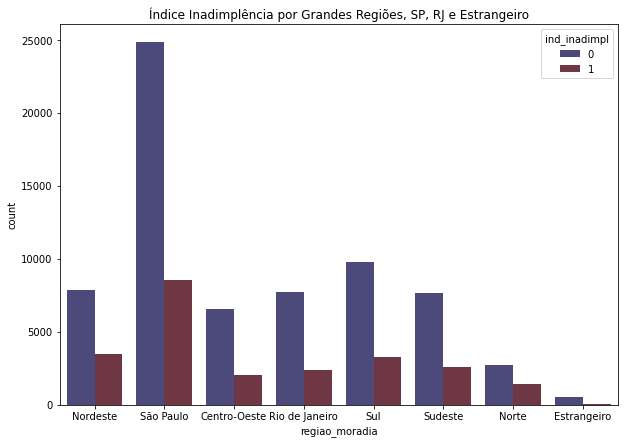

In [18]:
plt.figure(figsize=(10,7))

plot1 = sns.countplot(x="regiao_moradia", hue="ind_inadimpl",
                      palette= "icefire", data=base_dados)

plot1.set_title('Índice Inadimplência por Grandes Regiões, SP, RJ e Estrangeiro')

* O gráfico acima apresenta visualmente os valores apresentados anterior a Análise Gráfica.

* É possivel afirmar que a maioria dos clientes analisados são adimplentes nos contratos firmados em todas regiões de moradia consideradas.

Text(0.5, 1.0, 'Índice Inadimplência por Situção de Pagamentos')

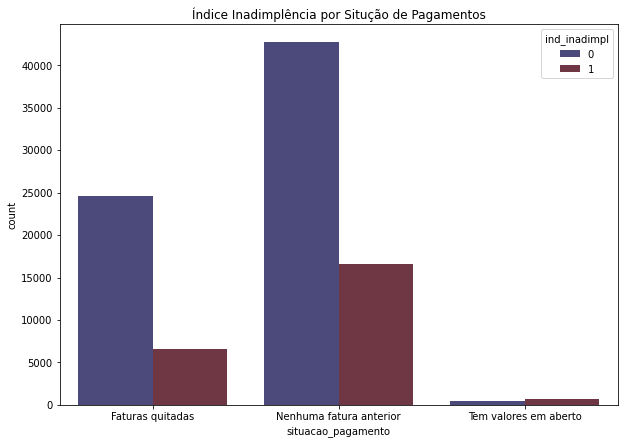

In [19]:
plt.figure(figsize=(10,7))

plot2 = sns.countplot(x="situacao_pagamento", hue="ind_inadimpl", 
                      palette= "icefire", data=base_dados)

plot2.set_title('Índice Inadimplência por Situção de Pagamentos')

* Somente na categoria 'Tem valores em aberto' que há mais clientes inadimplentes do que clientes adimplentes.

* A maioria dos clientes adimplentes e inadiplemtes encontra-se na categoria 'Nenhuma fatura anterior'.

Text(0.5, 1.0, 'Grandes Regiões, SP, RJ e Estrangeiro por Situção de Valores Vencidos em Aberto')

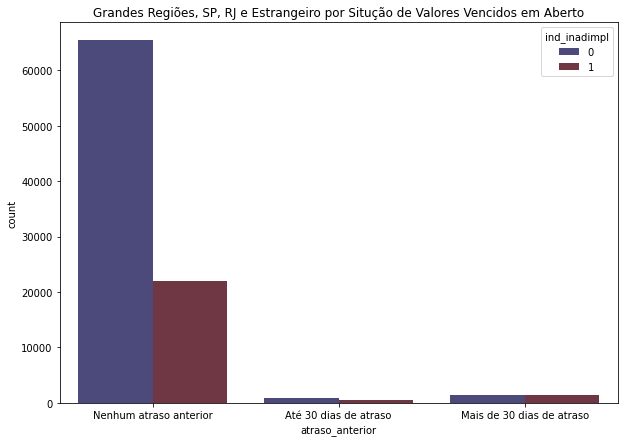

In [21]:
plt.figure(figsize=(10,7))

plot3 = sns.countplot(x="atraso_anterior", hue="ind_inadimpl", 
                      palette= "icefire", data=base_dados)

plot3.set_title('Grandes Regiões, SP, RJ e Estrangeiro por Situção de Valores Vencidos em Aberto')

* A maioria dos clientes adimplentes e inadiplemtes encontra-se na categoria 'Nenhum atraso anterior'.

* A categoria 'Mais de 30 dias de atraso' possui a mesma quantidade de clientes adimplentes e inadimplentes.

Text(0.5, 1.0, 'Grandes Regiões, SP, RJ e Estrangeiro por Situção de Valores Vencidos em Aberto')

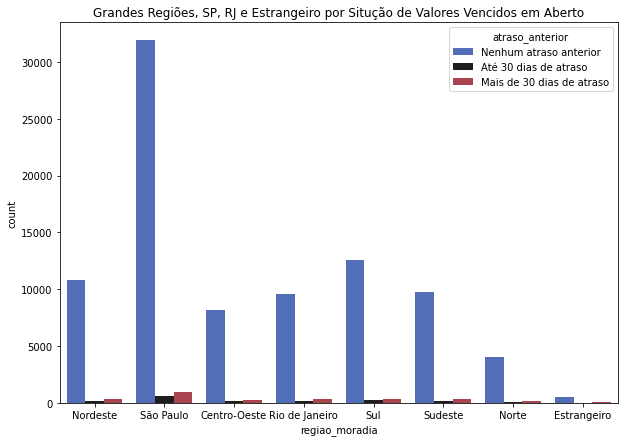

In [22]:
plt.figure(figsize=(10,7))

plot4 = sns.countplot(x="regiao_moradia", hue="atraso_anterior",
                      palette= "icefire", data=base_dados)

plot4.set_title('Grandes Regiões, SP, RJ e Estrangeiro por Situção de Valores Vencidos em Aberto')

* Em todas as regiões e estados considerados, a maioria dos clientes não possuiam valores em aberto no momento do contrato de referência.

* A categoria com menos clientes em todos as regiões e estados considerados é 'Mais de 30 dias de atraso'

<Figure size 720x504 with 0 Axes>

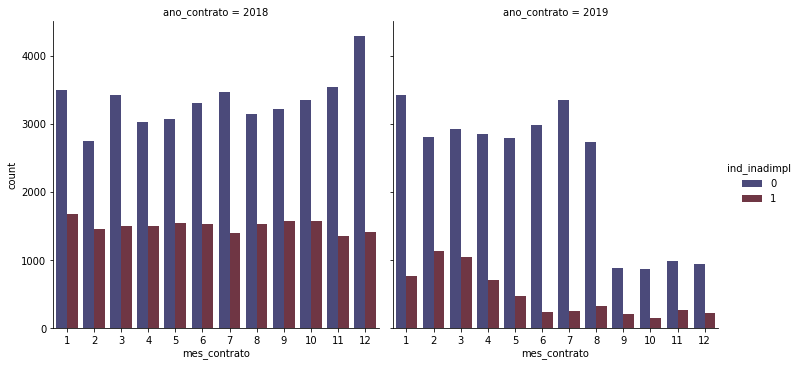

In [23]:
plt.figure(figsize=(10,7))

plot5 = sns.catplot(x="mes_contrato", hue="ind_inadimpl", kind="count",
                      col="ano_contrato", palette= "icefire", data=base_dados)



* No ano de 2018, o mês com mais contratos de referência corresponde a dezembro, que é o mês com mais clientes adimplentes. O mês do contrato de referência com mais clientes inadimplentes corresponde a janeiro.

* Já no ano de 2019, o mês com mais contratos de referência corresponde a janeiro, que é o mês com mais clientes adimplentes. O mês do contrato de referência com mais clientes inadimplentes corresponde a fevereiro.

* Verifica-se que a maioria dos contratos de refrência foram realizados no ano de 2018.

* A correlação entre as variáveis numéricas tem por objetivo verificar a influência de cada variável em relação as demais, seja de forma positiva ou negativa. 

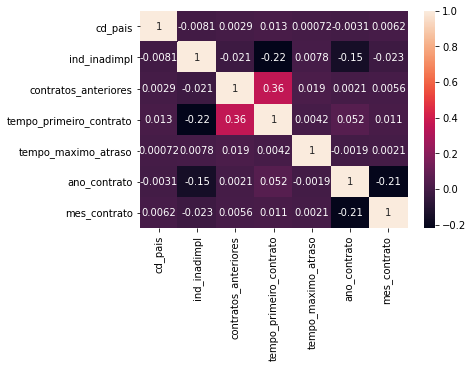

In [24]:
#Tabela correlação via Pearson que é o coeficiente de correlação padrão

base_corr = base_dados.corr(method='pearson',  min_periods=1)

#Heatmap

heatmap = sns.heatmap(base_corr, annot=True)


* Percebe-se que a maior influência positiva ocorre entre as variáveis 'contratos anteriores' e 'tempo_primeiro_contrato'.


* A maior influência negativa está entre as variáveis 'ind_inapimpl' e 'tempo_primeiro_contrato'.

#Pré Processamento

* O pré processamento da base de dados consiste em retirar as variáveis que não fazem sentido compor o modelo de estatístico a ser desenvolvido, tais como identificador do cliente e identificador do contrato de referência e variáveis de data.

* Após tal passo, as colunas numéricas são padronizadas em um intervalo entre 0 e 1, por não apresentarem valores negativos, e as variáveis categóricas são transformadas em variáveis dummies, onde 1 indica a ocorrência da categoria da variável.

In [25]:
base_dados2 = base_dados.drop(['Cliente', 'dt_nascimento', 'cd_estado', 'cd_pais',
                               'cd_contrato', 'data_abertura','data_primeiro_contrato',
                               'data_nascimento', 'ano_contrato', 'mes_contrato'], 
                              axis=1, inplace=False)

In [26]:
base_dados2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91638 entries, 0 to 91637
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ind_inadimpl             91638 non-null  int64 
 1   regiao_moradia           91638 non-null  object
 2   contratos_anteriores     91638 non-null  int64 
 3   tempo_primeiro_contrato  91638 non-null  int64 
 4   situacao_pagamento       91638 non-null  object
 5   tempo_maximo_atraso      91638 non-null  int64 
 6   atraso_anterior          91638 non-null  object
dtypes: int64(4), object(3)
memory usage: 4.9+ MB


In [27]:
base_dados2.describe()

,ind_inadimpl,contratos_anteriores,tempo_primeiro_contrato,tempo_maximo_atraso
count,91638.000000,91638.000000,91638.000000,91638.000000
mean,0.260754,4.004638,43.701718,10.481580
std,0.439048,11.160166,62.906954,1195.315658
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,13.000000,0.000000
75%,1.000000,3.000000,69.000000,0.000000
max,1.000000,528.000000,298.000000,361566.000000


In [28]:
#Colunas numéricas - Transformação para intervalo

base_num = base_dados2.select_dtypes(exclude=['object'])

#Método para reescalar variáveis numéricas: MinMaxScaler() 
#Justificativa: Preserva a distribuição original das variáveis e o cálculo
#de reescalonamento é independente entre as variáveis

scaler = MinMaxScaler()

X_num = scaler.fit_transform(base_num)

base_num_input = pd.DataFrame(X_num, index=base_num.index, columns=base_num.columns)

In [29]:
#Colunas categóricas - Transformação para dummies

base_cat = base_dados2.select_dtypes(include=['object'])

base_cat = pd.get_dummies(base_cat, drop_first=False)

In [30]:
base_prepared = pd.concat([base_num_input, base_cat], axis=1)
base_prepared.head()

,ind_inadimpl,contratos_anteriores,tempo_primeiro_contrato,tempo_maximo_atraso,regiao_moradia_Centro-Oeste,regiao_moradia_Estrangeiro,regiao_moradia_Nordeste,regiao_moradia_Norte,regiao_moradia_Rio de Janeiro,regiao_moradia_Sudeste,regiao_moradia_Sul,regiao_moradia_São Paulo,situacao_pagamento_Faturas quitadas,situacao_pagamento_Nenhuma fatura anterior,situacao_pagamento_Tem valores em aberto,atraso_anterior_Até 30 dias de atraso,atraso_anterior_Mais de 30 dias de atraso,atraso_anterior_Nenhum atraso anterior
0,1.0,0.005682,0.000000,0.000000,0,0,1,0,0,0,0,0,1,0,0,0,0,1
1,1.0,0.011364,0.902685,0.000055,0,0,0,0,0,0,0,1,1,0,0,1,0,0
2,1.0,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,1,0,1,0,0,0,1
3,1.0,0.001894,0.023490,0.000351,0,0,0,0,0,0,0,1,1,0,0,0,1,0
4,1.0,0.007576,0.926174,0.000000,1,0,0,0,0,0,0,0,0,1,0,0,0,1


In [31]:
base_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91638 entries, 0 to 91637
Data columns (total 18 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   ind_inadimpl                                91638 non-null  float64
 1   contratos_anteriores                        91638 non-null  float64
 2   tempo_primeiro_contrato                     91638 non-null  float64
 3   tempo_maximo_atraso                         91638 non-null  float64
 4   regiao_moradia_Centro-Oeste                 91638 non-null  uint8  
 5   regiao_moradia_Estrangeiro                  91638 non-null  uint8  
 6   regiao_moradia_Nordeste                     91638 non-null  uint8  
 7   regiao_moradia_Norte                        91638 non-null  uint8  
 8   regiao_moradia_Rio de Janeiro               91638 non-null  uint8  
 9   regiao_moradia_Sudeste                      91638 non-null  uint8  
 10  regiao_mor

In [32]:
base_prepared.describe()

,ind_inadimpl,contratos_anteriores,tempo_primeiro_contrato,tempo_maximo_atraso,regiao_moradia_Centro-Oeste,regiao_moradia_Estrangeiro,regiao_moradia_Nordeste,regiao_moradia_Norte,regiao_moradia_Rio de Janeiro,regiao_moradia_Sudeste,regiao_moradia_Sul,regiao_moradia_São Paulo,situacao_pagamento_Faturas quitadas,situacao_pagamento_Nenhuma fatura anterior,situacao_pagamento_Tem valores em aberto,atraso_anterior_Até 30 dias de atraso,atraso_anterior_Mais de 30 dias de atraso,atraso_anterior_Nenhum atraso anterior
count,91638.000000,91638.000000,91638.000000,91638.000000,91638.000000,91638.000000,91638.000000,91638.000000,91638.000000,91638.000000,91638.000000,91638.000000,91638.000000,91638.000000,91638.000000,91638.000000,91638.000000,91638.000000
mean,0.260754,0.007585,0.146650,0.000029,0.093717,0.006733,0.123715,0.045865,0.110522,0.112366,0.142856,0.364227,0.339794,0.647319,0.012888,0.016292,0.030533,0.953174
std,0.439048,0.021137,0.211097,0.003306,0.291436,0.081779,0.329258,0.209194,0.313541,0.315818,0.349927,0.481215,0.473642,0.477807,0.112791,0.126598,0.172050,0.211266
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.001894,0.043624,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.005682,0.231544,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#Construção do Modelo

* Variável resposta (y): 'ind_inadimpl';
* 30% da base de dados foi destinada para base teste  do modelo desenvolvido;
* Balanceamendo dos dados: Under Sampling;
* Modelo estatístico utilizado: Random Forest Classifier em conjunto com Análise de Componentes Principais (PCA);
* Acurácia do modelo com Validação Cruzada;
* Otimização do modelo desenvolvido: GridSearchCV.

In [33]:
#SEED = 42 - escolha arbitrária
SEED = 42
np.random.seed(SEED)

#Separação das variáveis independentes e dependente/resposta
X = base_prepared.drop('ind_inadimpl', axis=1)
y = base_prepared['ind_inadimpl']

#Separação dados: 70% treino 70% e 30% teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.3, stratify=y ,
                                                   random_state=SEED)

In [34]:
#Balanceamendo dos dados: Under-sampling 
#Justificativa: Preservar as caraterísticas da classe minoritária
#e porque a base possui volume de dados.

rus = RandomUnderSampler()
X_resp, y_resp = rus.fit_sample(X_treino, y_treino)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [35]:
#Random Forest Classifier: Problema de classificação binária
#Análise de Componentes Principais (PCA): redução de problemas 
#de dimensionalidade

#Número de árvores da RF = 10 - escolha arbitrária 

modelo_rf = Pipeline(steps=[                                                                  
    ('PCA', PCA()),
    ('rf_clf', RandomForestClassifier(n_estimators=10, random_state=SEED))                   
])

#Treino do modelo
modelo_rf.fit(X_treino, y_treino)

#Previsões utilizando a base X_teste
y_pred_rf = modelo_rf.predict(X_teste)
y_pred_rf

array([0., 0., 0., ..., 0., 0., 0.])

In [36]:
#Probabilidade da variável resposta da base de teste assumir a classifcação
#0 (adimplente) ou 1 (inadimplente) conforme features do modelo

modelo_rf.predict_proba(X_teste)[0:5]

array([[0.73468756, 0.26531244],
       [0.58333333, 0.41666667],
       [0.94166667, 0.05833333],
       [0.52466789, 0.47533211],
       [1.        , 0.        ]])

* Probabilidade das 5 primeiras entradas da base de teste ser classificada como 0 (adimplente) ou 1 (inadimplente).

In [37]:
#Acurácia do modelo desenvolvido

accuracy_rf = accuracy_score(y_teste, y_pred_rf)
print(f'Acurácia Modelo Random Forest Classifier: {accuracy_rf}')

Acurácia Modelo Random Forest Classifier: 0.7325767495998836


* O modelo desenvolvido possui uma Acurácia de 73,25%, ou seja, o modelo treinado possui 73,25% de chances de classificar o cliente como inadimplente (y = 1) corretamente.

* Para confirmar a acurácia encontrada, foi aaplicada Validação Cruzada no modelo desenvolvido

In [38]:
#Aleatorização dos dados para realizar Validação Cruzada
cv = StratifiedKFold(n_splits = 5, shuffle=True)
results_cv_rf = cross_validate(modelo_rf, X, y, cv=cv, return_train_score=False)

mean_cv_rf = results_cv_rf['test_score'].mean()
std_cv_rf = results_cv_rf['test_score'].std()
print('Accurácia média RF - com Cross Validation: %.2f' % (mean_cv_rf * 100))
print('Accurácia intervalo RF - com Cross Validation: [%.2f, %.2f]' % (
    (mean_cv_rf - 2 *std_cv_rf) * 100, (mean_cv_rf + 2 * std_cv_rf) * 100))

Accurácia média RF - com Cross Validation: 72.98
Accurácia intervalo RF - com Cross Validation: [72.76, 73.20]


* Resultado semelhante ao da Acurácia sem Validação Cruzada pode indicar um modelo bem treinado.

* Considerando que a base de dados utilizada são dados reais, a Acurácia acima dos 70% indica que o modelo desenvolvido possui um bom treino.



In [39]:
#Otimização do modelo via GridSearchCV

#Definição dos parâmetros a serem testados
param_grid_rf = [
    {'rf_clf__n_estimators':[10, 100], 'rf_clf__criterion': ['gini', 'entropy'], 'rf_clf__class_weight':['balanced']},
    {'rf_clf__bootstrap':[False], 'rf_clf__n_estimators':[10, 100], 'rf_clf__criterion': ['gini', 'entropy']}  
]

grid_search_rf = GridSearchCV(modelo_rf, param_grid_rf, 
                           cv = StratifiedKFold(n_splits = 5, shuffle=True), 
                           scoring='accuracy')
#treinamento com o GriSearch
grid_search_rf.fit(X_treino, y_treino)

#resultados obtidos com o treinamento de cada parâmetro
resultados_grid_rf = pd.DataFrame(grid_search_rf.cv_results_)
resultados_grid_rf.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf_clf__class_weight,param_rf_clf__criterion,param_rf_clf__n_estimators,param_rf_clf__bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.422082,0.010860,0.039029,0.002630,balanced,gini,10,NaN,"{'rf_clf__class_weight': 'balanced', 'rf_clf__...",0.616680,0.612519,0.613298,0.613688,0.610726,0.613382,0.001938,7
1,13.160518,0.126096,0.270414,0.006046,balanced,gini,100,NaN,"{'rf_clf__class_weight': 'balanced', 'rf_clf__...",0.616446,0.614623,0.613766,0.615325,0.612752,0.614582,0.001268,6
2,2.340602,0.047558,0.040754,0.000776,balanced,entropy,10,NaN,"{'rf_clf__class_weight': 'balanced', 'rf_clf__...",0.615666,0.613376,0.613766,0.612986,0.610804,0.613320,0.001559,8
3,22.484195,0.366359,0.286449,0.002165,balanced,entropy,100,NaN,"{'rf_clf__class_weight': 'balanced', 'rf_clf__...",0.617537,0.614701,0.614779,0.616338,0.612441,0.615159,0.001720,5
4,2.271679,0.045252,0.042548,0.000962,NaN,gini,10,False,"{'rf_clf__bootstrap': False, 'rf_clf__criterio...",0.725331,0.727570,0.728895,0.727337,0.726713,0.727169,0.001162,1


In [40]:
#Melhores parâmetros encontrados
grid_search_rf.best_params_

{'rf_clf__bootstrap': False,
 'rf_clf__criterion': 'gini',
 'rf_clf__n_estimators': 10}

In [41]:
#RandomForest treinado com os melhores parâmetros encontrados
best_est_rf = grid_search_rf.best_estimator_
best_est_rf.fit(X_treino, y_treino)

Pipeline(memory=None,
         steps=[('PCA',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('rf_clf',
                 RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=10, n_jobs=None,
                                        oob_score=False, random_state=42,
                

In [42]:
y_pred_acc_rf= best_est_rf.predict(X_teste)

#Avaliação Modelo Random Forest Classifier com PCA

* Acurácia; 
* Precisão;
* Sensibilidade;
* F1-Score;
* Matriz de Confusão;
* Grau de importância para cada feature do modelo;


Temos o precision(precisão) que nos diz o quão preciso está sendo o nosso modelo na hora de acertar a classificação. O recall(revocação) é a fração de instâncias relevantes que são recuperadas. E o f1-score é uma média harmônica de ambos.

In [43]:
print('Score Acurácia: ' + str(accuracy_score(y_teste,y_pred_acc_rf)))
print('Score Precisão: ' + str(precision_score(y_teste,y_pred_acc_rf)))
print('Score Sensibilidade: ' + str(recall_score(y_teste,y_pred_acc_rf)))
print('F1-Score: ' + str(f1_score(y_teste,y_pred_acc_rf)))

Score Acurácia: 0.7300305543430816
Score Precisão: 0.41864951768488745
Score Sensibilidade: 0.09080764402287628
F1-Score: 0.1492434662998625


* Acurácia: Probabilidade do modelo treinado apresentar um verdadeiro positivo, ou seja, classificar corretamente a variável dependente;
* Precisão: O quanto o modelo efetivamente acerta, considerando todos os verdadeiros positivos e falsos positivos; 
* Sensibilidade: Fração de observações revelantes que são selecionadas;
* F1-Score: Média harmônica entre precisão e sensibilidade.

[[19419   904]
 [ 6518   651]]


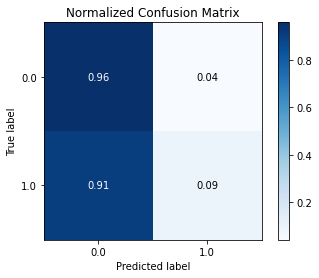

In [44]:
print(confusion_matrix(y_teste, y_pred_acc_rf))

#Matrix de Confusão
skplt.metrics.plot_confusion_matrix(y_teste, y_pred_acc_rf, normalize=True);

* Estrutura Matriz de Confusão:

[*Verdadeiros Negativos*, *Falsos Positivos*

*Falsos Negativos*, *Verdadeiros Positivos*]

* A Matriz de Confusão do modelo treinado indica que o modelo possui uma precisão elevada para classificar o cliente como adimplente (0) quando o mesmo é adimplente.

* A Matriz de Confusão domodelo treinado indica que o modelo classifica o cliente como adimplente (0) quando o mesmo é inadimplente (1).

In [45]:
#Principais métricas desenvolvidas

print(classification_report(y_teste, y_pred_acc_rf))

              precision    recall  f1-score   support

         0.0       0.75      0.96      0.84     20323
         1.0       0.42      0.09      0.15      7169

    accuracy                           0.73     27492
   macro avg       0.58      0.52      0.49     27492
weighted avg       0.66      0.73      0.66     27492



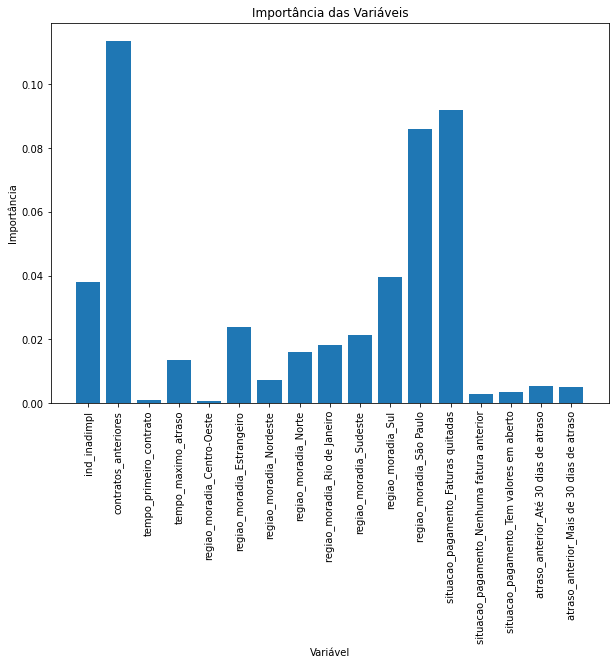

In [49]:
#Importância de cada feature no modelo treinado

#Levantamento da importância de cada feature do modelo
perm = PermutationImportance(modelo_rf, random_state=1).fit(X_teste, y_teste)

#Lista de features do modelo treinado
feature_list = list(base_prepared.columns)

importancia = list(perm.feature_importances_)

x_values = list(range(len(importancia)))

plt.figure(figsize=(10,7))

plt.bar(x_values, importancia, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importância'); plt.xlabel('Variável'); plt.title('Importância das Variáveis');   

* Verifca-se que as features com mais relevância no modelo são:

1.   'contratos_anteriores'
2.   'situacao_pagamento_Faturas quitadas'
3.   'regiao_moradia_São Paulo'





